In [1]:
import tensorflow as tf
import os

In [2]:
import xml.etree.ElementTree as ET 

labelpath = os.path.join(os.getcwd(), 'kangaroo', 'annots') 
imagepath = os.path.join(os.getcwd(), 'kangaroo', 'images') 


labelnames = os.listdir(labelpath)


Trainfile = open('train.txt','w')


for labelfile in labelnames:
    
    XMLpath = labelpath + '/' + labelfile
    Ppath = imagepath + '/' + labelfile[0:-3] + 'jpg'

    
    Trainfile.write(Ppath)
    
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            bbx = obj.find('bndbox')

            Trainfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            Trainfile.write(',0')
    Trainfile.write('\n')       
Trainfile.close()

In [3]:
labelpath = os.path.join(os.getcwd(), 'raccoon_dataset', 'annotations') 
imagepath = os.path.join(os.getcwd(), 'raccoon_dataset', 'images') 

labelnames = os.listdir(labelpath)

Trainfile = open('train.txt','a')

for labelfile in labelnames:
    XMLpath = labelpath + '/' + labelfile
    Ppath = imagepath + '/' + labelfile[0:-3] + 'jpg'
    
    Trainfile.write(Ppath)
    
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            bbx = obj.find('bndbox')
            Trainfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            Trainfile.write(',1')
    Trainfile.write('\n')     
Trainfile.close()

In [4]:
path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),  'keras-yolo3')
os.chdir(path)

In [5]:
import numpy as np
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES =True
annots_path = 'train.txt'
classes_path = 'model_data/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

log_dir='logs'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

model = create_model(input_shape, anchors, num_classes,
    freeze_body=2, weights_path='model_data/yolo.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annots_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
if True:
    model.compile(optimizer=Adam(lr=1e-4), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\Bill\Anaconda3\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatc

Load weights model_data/yolo.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 328 samples, val on 36 samples, with batch size 16.



Epoch 1/50
20/20 [==============================] - 39s 2s/step - loss: 4101.0185 - val_loss: 1119.7542

Epoch 2/50
20/20 [==============================] - 30s 2s/step - loss: 620.3323 - val_loss: 312.8036
Epoch 3/50
20/20 [==============================] - 31s 2s/step - loss: 259.5228 - val_loss: 175.2744
Epoch 4/50
20/20 [==============================] - 15s 772ms/step - loss: 178.5120 - val_loss: 147.8395
Epoch 5/50
20/20 [==============================] - 31s 2s/step - loss: 140.0947 - val_loss: 108.5460
Epoch 6/50
20/20 [==============================] - 31s 2s/step - loss: 116.0660 - val_loss: 102.1694
Epoch 7/50
20/20 [==============================] - 31s 2s/step - loss: 99.0416 - val_loss: 93.7759
Epoch 8/50
20/20 [========================

In [6]:
from yolo import YOLO
model = YOLO(model_path="logstrained_weights.h5",anchors_path="model_data/yolo_anchors.txt",  classes_path=classes_path) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
logstrained_weights.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
from PIL import Image
image = Image.open('raccoon-wiki.jpg')

In [8]:
r_image = model.detect_image(image)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (31, 0) (188, 228)
2.6834103999999996


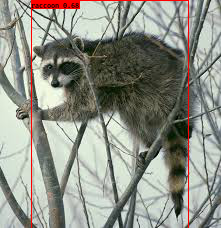

In [9]:
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (33, 8) (219, 194)
0.052903300000004094


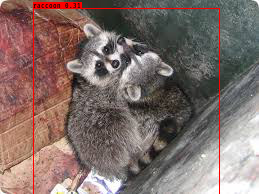

In [10]:
image = Image.open('raccoon-198.jpg')
r_image = model.detect_image(image)
r_image

In [11]:
from yolo import detect_video
detect_video(model, 'Raccoon.mp4', 'raccoon_output.mp4')

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 0 boxes for img
0.05895490000000336
(416, 416, 3)
Found 0 boxes for img
0.06162510000000054
(416, 416, 3)
Found 0 boxes for img
0.05603010000000097
(416, 416, 3)
Found 0 boxes for img
0.05499380000000542
(416, 416, 3)
Found 0 boxes for img
0.054561499999998375
(416, 416, 3)
Found 0 boxes for img
0.053157599999998695
(416, 416, 3)
Found 0 boxes for img
0.05469310000000149
(416, 416, 3)
Found 0 boxes for img
0.05589780000000388
(416, 416, 3)
Found 0 boxes for img
0.055802499999998645
(416, 416, 3)
Found 0 boxes for img
0.05506729999999749
(416, 416, 3)
Found 0 boxes for img
0.05588490000000235
(416, 416, 3)
Found 0 boxes for img
0.05483770000000021
(416, 416, 3)
Found 0 boxes for img
0.05788340000000147
(416, 416, 3)
Found 0 boxes for img
0.05507769999999823
(416, 416, 3)
Found 0 boxes for img
0.0558078999999978
(416, 416, 3)
Found 0 boxes for img
0.05924699999999916
(416, 416, 3)
Found 0 boxes for 

Found 0 boxes for img
0.05412809999999979
(416, 416, 3)
Found 0 boxes for img
0.05445879999999903
(416, 416, 3)
Found 0 boxes for img
0.0536500999999987
(416, 416, 3)
Found 0 boxes for img
0.05428309999999925
(416, 416, 3)
Found 0 boxes for img
0.05423169999999544
(416, 416, 3)
Found 0 boxes for img
0.054943600000001425
(416, 416, 3)
Found 0 boxes for img
0.056260099999995816
(416, 416, 3)
Found 0 boxes for img
0.05396069999999753
(416, 416, 3)
Found 0 boxes for img
0.05391159999999928
(416, 416, 3)
Found 0 boxes for img
0.055804599999994764
(416, 416, 3)
Found 0 boxes for img
0.054470699999995986
(416, 416, 3)
Found 0 boxes for img
0.05378340000000037
(416, 416, 3)
Found 0 boxes for img
0.05417059999999907
(416, 416, 3)
Found 0 boxes for img
0.054278700000004676
(416, 416, 3)
Found 0 boxes for img
0.05557009999999707
(416, 416, 3)
Found 0 boxes for img
0.05608949999999879
(416, 416, 3)
Found 0 boxes for img
0.05689650000000057
(416, 416, 3)
Found 0 boxes for img
0.054934699999996894
(

Found 0 boxes for img
0.053884999999993966
(416, 416, 3)
Found 0 boxes for img
0.05420050000000032
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (555, 34) (1171, 538)
0.05635689999999727
(416, 416, 3)
Found 0 boxes for img
0.0540051000000048
(416, 416, 3)
Found 0 boxes for img
0.054174299999999675
(416, 416, 3)
Found 0 boxes for img
0.056159300000004464
(416, 416, 3)
Found 0 boxes for img
0.05512149999999849
(416, 416, 3)
Found 0 boxes for img
0.055396399999999346
(416, 416, 3)
Found 0 boxes for img
0.054226299999996286
(416, 416, 3)
Found 0 boxes for img
0.05463550000000339
(416, 416, 3)
Found 0 boxes for img
0.0539828
(416, 416, 3)
Found 0 boxes for img
0.05458809999999659
(416, 416, 3)
Found 0 boxes for img
0.05534770000000577
(416, 416, 3)
Found 0 boxes for img
0.054732100000002504
(416, 416, 3)
Found 0 boxes for img
0.05444179999999932
(416, 416, 3)
Found 0 boxes for img
0.054469399999995005
(416, 416, 3)
Found 0 boxes for img
0.053879999999999484
(416, 416, 3)
Found 0 boxes fo

Found 1 boxes for img
raccoon 0.36 (191, 0) (1079, 720)
0.057454199999995126
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (183, 0) (1084, 720)
0.05634279999999592
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (195, 0) (1070, 720)
0.05682260000000383
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (196, 0) (1066, 720)
0.05563089999999704
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (199, 0) (1063, 720)
0.057228399999999624
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (188, 0) (1070, 720)
0.05643689999999424
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (193, 0) (1063, 720)
0.05649800000000482
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (221, 0) (1035, 720)
0.056456599999989976
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (226, 0) (1029, 720)
0.05612379999999462
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (205, 0) (1053, 720)
0.056123700000000554
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (206, 0) (1058, 720)
0.056775200000004133
(416, 416, 3)
Found

Found 1 boxes for img
raccoon 0.30 (67, 0) (1244, 720)
0.05778680000000236
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (74, 0) (1243, 720)
0.058162499999994566
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (67, 0) (1250, 720)
0.057165400000002364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (47, 0) (1269, 720)
0.05959529999999802
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (43, 0) (1264, 720)
0.056683399999997164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (73, 0) (1232, 720)
0.05840560000000039
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (82, 0) (1218, 720)
0.059515500000003385
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (63, 0) (1236, 720)
0.056602599999990844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (63, 0) (1239, 720)
0.056601199999988694
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (60, 0) (1245, 720)
0.05581250000000182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (76, 0) (1230, 720)
0.05782959999999093
(416, 416, 3)
Found 1 boxes f

Found 0 boxes for img
0.05719599999999048
(416, 416, 3)
Found 0 boxes for img
0.05480959999999868
(416, 416, 3)
Found 0 boxes for img
0.05457110000000398
(416, 416, 3)
Found 0 boxes for img
0.05495590000001016
(416, 416, 3)
Found 0 boxes for img
0.054357600000003004
(416, 416, 3)
Found 0 boxes for img
0.05456339999999216
(416, 416, 3)
Found 0 boxes for img
0.053412600000001476
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 0) (1064, 720)
0.05680730000000267
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (0, 0) (1067, 720)
0.05865020000000243
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 0) (1163, 720)
raccoon 0.46 (105, 0) (825, 720)
0.05928020000000345
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 0) (1167, 720)
raccoon 0.46 (108, 0) (821, 720)
0.058503799999996886
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (112, 0) (811, 720)
0.05611420000001033
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (113, 0) (812, 720)
0.05896989999999391
(416, 416, 3)
Found 1 b

Found 1 boxes for img
kangaroo 0.34 (35, 289) (407, 720)
0.05785389999999779
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (32, 288) (413, 720)
0.05771990000000926
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (28, 275) (416, 720)
0.05627580000000876
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (30, 273) (412, 720)
0.05608180000000118
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (31, 279) (412, 720)
0.056938299999998776
(416, 416, 3)
Found 0 boxes for img
0.05360620000000438
(416, 416, 3)
Found 0 boxes for img
0.05451970000000017
(416, 416, 3)
Found 0 boxes for img
0.054143199999998615
(416, 416, 3)
Found 0 boxes for img
0.054252300000001696
(416, 416, 3)
Found 0 boxes for img
0.05477589999999566
(416, 416, 3)
Found 0 boxes for img
0.059223600000009924
(416, 416, 3)
Found 0 boxes for img
0.054670099999995614
(416, 416, 3)
Found 0 boxes for img
0.054739099999991936
(416, 416, 3)
Found 0 boxes for img
0.054208500000001436
(416, 416, 3)
Found 0 boxes for img
0.0546782999

Found 1 boxes for img
raccoon 0.33 (164, 0) (1086, 720)
0.05650280000000407
(416, 416, 3)
Found 0 boxes for img
0.054922399999995264
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (161, 0) (971, 720)
0.05670070000000749
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (159, 0) (965, 720)
0.05747490000000255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (159, 0) (949, 720)
0.055756999999999834
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (173, 0) (914, 720)
0.055849699999996005
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (203, 0) (870, 720)
0.05587580000000969
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (219, 0) (845, 720)
0.05728599999999062
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (172, 0) (878, 720)
0.056611099999997805
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (120, 0) (919, 720)
0.05612250000000074
(416, 416, 3)
Found 0 boxes for img
0.05444980000000044
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (21, 0) (928, 720)
0.056841399999996156
(416, 4

Found 0 boxes for img
0.0538657000000029
(416, 416, 3)
Found 0 boxes for img
0.05464249999999993
(416, 416, 3)
Found 0 boxes for img
0.053734399999996185
(416, 416, 3)
Found 0 boxes for img
0.05379659999999831
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (495, 0) (1160, 720)
0.05625529999998946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (471, 0) (1177, 720)
0.059172799999998915
(416, 416, 3)
Found 0 boxes for img
0.05498310000000117
(416, 416, 3)
Found 0 boxes for img
0.05464369999999974
(416, 416, 3)
Found 0 boxes for img
0.05395749999999566
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (489, 0) (1136, 699)
0.05658770000000857
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (455, 36) (1164, 657)
0.05656380000000638
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (506, 0) (1108, 714)
0.05839110000000858
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (462, 0) (1047, 720)
0.05633490000001018
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (479, 0) (1038, 720)
0.05668529

Found 0 boxes for img
0.05418210000000556
(416, 416, 3)
Found 0 boxes for img
0.0615582999999873
(416, 416, 3)
Found 0 boxes for img
0.06175890000000095
(416, 416, 3)
Found 0 boxes for img
0.054278799999991634
(416, 416, 3)
Found 0 boxes for img
0.055031799999994746
(416, 416, 3)
Found 0 boxes for img
0.054607699999991155
(416, 416, 3)
Found 0 boxes for img
0.05721010000000604
(416, 416, 3)
Found 0 boxes for img
0.055089099999989344
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (375, 122) (965, 720)
0.06178710000000365
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (365, 104) (957, 720)
0.05855300000000341
(416, 416, 3)
Found 0 boxes for img
0.054568399999993744
(416, 416, 3)
Found 0 boxes for img
0.054004799999987085
(416, 416, 3)
Found 0 boxes for img
0.05591149999999345
(416, 416, 3)
Found 0 boxes for img
0.056208799999993175
(416, 416, 3)
Found 0 boxes for img
0.056353699999988294
(416, 416, 3)
Found 0 boxes for img
0.05533760000000143
(416, 416, 3)
Found 0 boxes for img
0.055

Found 1 boxes for img
raccoon 0.47 (240, 0) (1048, 720)
0.056770200000002546
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (191, 7) (1094, 720)
0.057536400000003596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (214, 0) (1084, 720)
0.05769700000000455
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (271, 0) (1014, 720)
0.056392400000007115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (234, 0) (1045, 720)
0.0572832999999946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (188, 7) (1095, 720)
0.05656749999999988
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (209, 0) (1079, 720)
0.05706930000000909
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (198, 29) (1094, 720)
0.05691090000000543
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (211, 32) (1076, 720)
0.05663660000000448
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (242, 30) (1044, 720)
0.05626939999999081
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (264, 9) (1017, 720)
0.0564358000000027
(416, 416, 3)
Found 

Found 1 boxes for img
raccoon 0.32 (0, 0) (1178, 720)
0.055562100000003056
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (0, 0) (1207, 720)
0.058290999999996984
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (0, 0) (1083, 720)
0.0562159000000122
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (18, 0) (1025, 720)
0.056474600000001374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (21, 7) (1011, 720)
0.05629700000000071
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 0) (989, 720)
0.05752440000000547
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (0, 0) (850, 720)
0.0569240000000093
(416, 416, 3)
Found 0 boxes for img
0.05708730000000628
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (765, 720)
0.0571145000000115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (0, 0) (758, 720)
0.05840709999998239
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 0) (702, 720)
0.05689189999998234
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (0, 0) (683, 720)
0.056958800000

Found 0 boxes for img
0.053836999999987256
(416, 416, 3)
Found 0 boxes for img
0.053509200000007695
(416, 416, 3)
Found 0 boxes for img
0.05534750000001054
(416, 416, 3)
Found 0 boxes for img
0.056073199999985945
(416, 416, 3)
Found 0 boxes for img
0.054776099999997996
(416, 416, 3)
Found 0 boxes for img
0.05408309999998551
(416, 416, 3)
Found 0 boxes for img
0.05494229999999334
(416, 416, 3)
Found 0 boxes for img
0.05423239999998941
(416, 416, 3)
Found 0 boxes for img
0.05459349999998153
(416, 416, 3)
Found 0 boxes for img
0.05723230000000967
(416, 416, 3)
Found 0 boxes for img
0.05441550000000461
(416, 416, 3)
Found 0 boxes for img
0.05502960000001167
(416, 416, 3)
Found 0 boxes for img
0.054086400000016965
(416, 416, 3)
Found 0 boxes for img
0.054268699999994396
(416, 416, 3)
Found 0 boxes for img
0.05462909999999965
(416, 416, 3)
Found 0 boxes for img
0.054483099999998785
(416, 416, 3)
Found 0 boxes for img
0.05469349999998485
(416, 416, 3)
Found 0 boxes for img
0.05391769999999951

Found 0 boxes for img
0.055458399999992025
(416, 416, 3)
Found 0 boxes for img
0.057150699999994004
(416, 416, 3)
Found 0 boxes for img
0.05600019999999972
(416, 416, 3)
Found 0 boxes for img
0.05689369999998917
(416, 416, 3)
Found 0 boxes for img
0.054061799999999494
(416, 416, 3)
Found 0 boxes for img
0.054701499999993075
(416, 416, 3)
Found 0 boxes for img
0.05540489999998499
(416, 416, 3)
Found 0 boxes for img
0.06107979999998747
(416, 416, 3)
Found 0 boxes for img
0.05430899999998928
(416, 416, 3)
Found 0 boxes for img
0.05481529999997292
(416, 416, 3)
Found 0 boxes for img
0.055992300000013984
(416, 416, 3)
Found 0 boxes for img
0.0553984000000014
(416, 416, 3)
Found 0 boxes for img
0.05643949999998199
(416, 416, 3)
Found 0 boxes for img
0.05439649999999574
(416, 416, 3)
Found 0 boxes for img
0.05431759999999031
(416, 416, 3)
Found 0 boxes for img
0.05427380000000426
(416, 416, 3)
Found 0 boxes for img
0.06037349999999719
(416, 416, 3)
Found 0 boxes for img
0.054787699999991446
(

Found 0 boxes for img
0.05550689999998326
(416, 416, 3)
Found 0 boxes for img
0.057642299999997704
(416, 416, 3)
Found 0 boxes for img
0.05551510000000803
(416, 416, 3)
Found 0 boxes for img
0.055895499999991216
(416, 416, 3)
Found 0 boxes for img
0.05568449999998393
(416, 416, 3)
Found 0 boxes for img
0.05500789999999256
(416, 416, 3)
Found 0 boxes for img
0.05490819999999985
(416, 416, 3)
Found 0 boxes for img
0.055653900000010026
(416, 416, 3)
Found 0 boxes for img
0.056397200000020575
(416, 416, 3)
Found 0 boxes for img
0.05488330000000019
(416, 416, 3)
Found 0 boxes for img
0.054825299999976096
(416, 416, 3)
Found 0 boxes for img
0.05543760000000475
(416, 416, 3)
Found 0 boxes for img
0.054986299999995936
(416, 416, 3)
Found 0 boxes for img
0.05434699999997861
(416, 416, 3)
Found 0 boxes for img
0.05636770000000979
(416, 416, 3)
Found 0 boxes for img
0.05750489999999786
(416, 416, 3)
Found 0 boxes for img
0.0597171000000003
(416, 416, 3)
Found 0 boxes for img
0.0569725999999946
(4

AttributeError: 'NoneType' object has no attribute '__array_interface__'